<a href="https://colab.research.google.com/github/yoonsung0186/ChungnamAI/blob/main/0708_openCV_canny%2BHSV%2BGaussian%20Block%2B%EB%85%B9%EC%83%89%20%EC%8B%A0%ED%98%B8%EB%93%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving cannyedge.png to cannyedge (37).png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49888 (\N{HANGUL SYLLABLE SIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54840 (\N{HANGUL SYLLABLE HO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46321 (\N{HANGUL SYLLABLE DEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/us

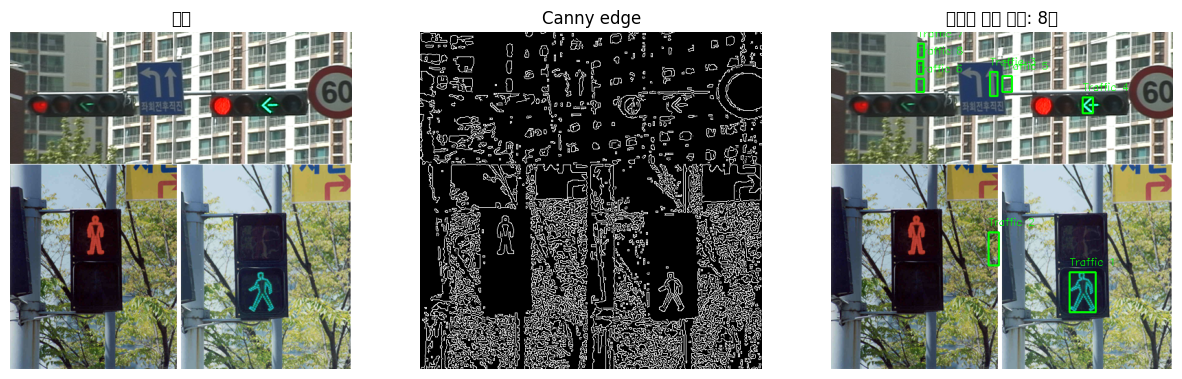

🚦 1: 위치=(347,350), 크기=(38x58)
🚦 2: 위치=(229,292), 크기=(15x48)
🚦 3: 위치=(231,59), 크기=(11x35)
🚦 4: 위치=(366,96), 크기=(15x23)
🚦 5: 위치=(249,65), 크기=(14x23)
🚦 6: 위치=(124,69), 크기=(11x19)
🚦 7: 위치=(126,18), 크기=(9x20)
🚦 8: 위치=(125,43), 크기=(9x19)


NameError: name 'counts' is not defined

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from google.colab import files

# 원형도 계산 함수
def compute_circularity(cnt):
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        return 0
    return 4 * np.pi * area / (perimeter * perimeter)

# NMS 적용 함수
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    if len(boxes) == 0:
        return []
    boxes = np.array(boxes)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]
    y2 = y1 + boxes[:, 3]
    scores = boxes[:, 2] * boxes[:, 3]
    idxs = np.argsort(scores)[::-1]
    pick = []
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        overlap = (w * h) / (boxes[idxs[1:], 2] * boxes[idxs[1:], 3])
        idxs = np.delete(idxs, np.concatenate(([0], np.where(overlap > overlapThresh)[0] + 1)))
    return boxes[pick].astype("int")

# 신호등 검출 함수
def detect_traffic_light_canny(image, min_area=100, max_area=10000, canny_low=50, canny_high=150):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # ✅ HSV 마스크 개선 (빨간색 범위 확장)
    red1 = cv2.inRange(hsv, (0, 10, 10), (10, 255, 255))
    red2 = cv2.inRange(hsv, (160, 20, 20), (180, 255, 255))
    red_mask = cv2.bitwise_or(red1, red2)
    yellow_mask = cv2.inRange(hsv, (18, 50, 50), (32, 255, 255))
    green_mask = cv2.inRange(hsv, (40, 40, 40), (85, 255, 255))
    blue_mask = cv2.inRange(hsv, (85, 40, 40), (105, 255, 255))

    total_mask = cv2.bitwise_or(cv2.bitwise_or(red_mask, yellow_mask), cv2.bitwise_or(green_mask, blue_mask))
    masked = cv2.bitwise_and(image, image, mask=total_mask)

    gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
    gray_eq = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray_eq, (3, 3), 0)
    edges = cv2.Canny(blurred, canny_low, canny_high)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    height = image.shape[0]
    candidates = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area or area > max_area:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        if y > height * 0.92:
            continue

        aspect_ratio = w / h
        if aspect_ratio < 0.3 or aspect_ratio > 0.7:
            continue

        circularity = compute_circularity(cnt)
        if circularity < 0.05:  # ✅ 더 유연하게 허용
            continue

        roi_r = red_mask[y:y+h, x:x+w]
        roi_g = green_mask[y:y+h, x:x+w]
        roi_b = blue_mask[y:y+h, x:x+w]
        roi_y = yellow_mask[y:y+h, x:x+w]
        counts = {
            'red': cv2.countNonZero(roi_r),
            'green': cv2.countNonZero(roi_g),
            'blue': cv2.countNonZero(roi_b),
            'yellow': cv2.countNonZero(roi_y),
        }

        active_colors = sum([v > 10 for v in counts.values()])
        if active_colors == 0:
            continue

        max_pixels = max(counts.values())
        if max_pixels / (w * h) < 0.2:  # ✅ 비율 완화
            continue

        roi_gray = gray[y:y+h, x:x+w]
        hist = cv2.calcHist([roi_gray], [0], None, [256], [0, 256])
        if np.max(hist) < 20:  # ✅ 히스토그램 기준 완화
            continue

        candidates.append((x, y, w, h))

    final_boxes = non_max_suppression_fast(candidates)
    return final_boxes, edges

# 시각화 함수
def draw_detections(image, detections):
    result = image.copy()
    for i, (x, y, w, h) in enumerate(detections):
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(result, f"Traffic {i+1}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return result

# 실행 함수 (Colab에서 이미지 업로드)
def upload_and_detect_custom():
    uploaded = files.upload()
    for name in uploaded.keys():
        img = Image.open(io.BytesIO(uploaded[name]))
        img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        h, w = img_cv.shape[:2]
        if w > 1200:
            img_cv = cv2.resize(img_cv, (1200, int(1200 * h / w)))

        detections, edges = detect_traffic_light_canny(img_cv)
        drawn = draw_detections(img_cv, detections)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        plt.title("원본")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(edges, cmap='gray')
        plt.title("Canny edge")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB))
        plt.title(f"신호등 검출 결과: {len(detections)}개")
        plt.axis("off")
        plt.show()

        for i, (x, y, w, h) in enumerate(detections):
            print(f"🚦 {i+1}: 위치=({x},{y}), 크기=({w}x{h})")

# 빨간색 영역일 경우 조건 완화
    if counts['red'] > 10 and max_pixels / (w * h) > 0.01:
        detections.append((x, y, w, h))


# 실행
upload_and_detect_custom()
